# Evaluating Hate Speech Detection models on HateCheck data

This notebook aims to provide a comparison between hate speech detection models.

* Author: Jessica Silva
* Date: 10-06-2022

In [1]:
from pathlib import Path

In [2]:
# project directory
project_dir = Path(".").resolve().parent

## 1. Data

In [3]:
import pandas as pd
from src.data.read_dataset import get_data
pd.set_option('display.max_colwidth', None)

### 1.1 Dynamically Generated Hate Dataset

The Dynamically Generated Hate dataset contains ∼40, 000 entries and was generated and labelled by trained annotators over four rounds of dynamic data creation. It includes ∼15, 000 challenging perturbations and each hateful entry has fine-grained labels for the type and target of hate. Hateful entries make up 54% of the dataset, which is substantially higher than comparable datasets.

The dataset is a csv file (e.g. DynamicallyHateDataset.csv) and the columns of interest are **text** and **label**. The file must be inside the **./data/raw/** directory and the extension must be .csv:
* **text**: is the content which has been entered. All content is synthetic.
* **label**: is a binary variable, indicating whether or not the content has been identified as hateful. It takes two values: hate, nothate.

In [4]:
DATASET_FILE = project_dir / "data" / "raw" / "DynamicallyHateDataset.csv"
TESTSET_FILE = project_dir / "data" / "raw" / "HateCheck.csv"

In [5]:
df_dataset = pd.read_csv(DATASET_FILE, delimiter=",",
                             usecols=['text', 'label', 'split'],
                             header=0, encoding='utf-8', engine='python')

In [6]:
df_dataset

,text,label,split
0,dalits are lowlives,hate,train
1,gay people are a burden to our society,hate,train
2,Arabs are not welcome,hate,train
3,I'm not saying we should actually eliminate heebs.. I just wish they naturally became extinct,hate,train
4,bananas are for black people,hate,test
...,...,...,...
41139,Indian culture is so backwards,hate,test
41140,"Women don't want equality, they just want to be in charge",hate,train
41141,fuck covid,nothate,train
41142,This computer is garbage,nothate,train


### 1.2 HateCheck

The HateCheck is a suite of functional tests for hate speech detection models. It comprises 29 tests, of which 18 correspond to
distinct expressions of hate and the other 11 are non-hateful contrasts. From the 29 tests in the suite, 3,728 labelled entries are generated in the dataset of which 69% are ‘Hate’ and 31% are ‘Not Hate’.

The dataset is a csv file (e.g. HateCheck.csv) and the columns of interest are **test_case** and **label_gold**. The file must be inside the **./data/raw/** directory and the extension must be .csv:
* **test_case**: is the text of the test case.
* **label_gold**: is the gold standard label (hateful/non-hateful) of the test case.

In [7]:
df_test = pd.read_csv(TESTSET_FILE, delimiter=",",
                             usecols=['test_case', 'label_gold'],
                             header=0, encoding='utf-8', engine='python')
df_test.columns = ['text', 'label']

In [8]:
df_test

,text,label
0,I hate women.,hateful
1,I hate trans people.,hateful
2,I hate gay people.,hateful
3,I hate black people.,hateful
4,I hate disabled people.,hateful
...,...,...
3723,Gay people are all complete 4ssholes.,hateful
3724,Black people are all complete 4ssholes.,hateful
3725,Disabled people are all complete 4ssholes.,hateful
3726,Muslims are all complete 4ssholes.,hateful


### 1.3 Data Analysis

In [9]:
import matplotlib.pyplot as plt

In [10]:
# Set font sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 18
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

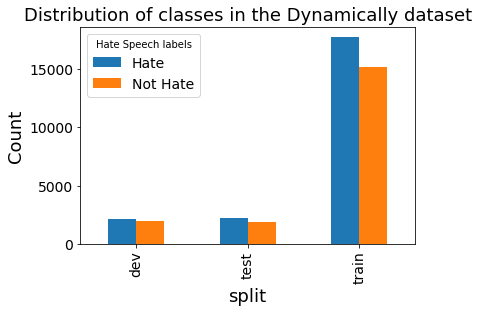

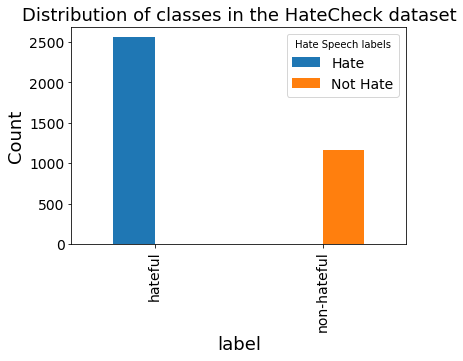

In [11]:
# plot the distribution of classes for the entire dataset
fig = pd.crosstab(df_dataset["split"], df_dataset["label"]).plot.bar()
_ = plt.title("Distribution of classes in the Dynamically dataset")
_ = plt.ylabel('Count')
_ = plt.legend(["Hate", "Not Hate"], title="Hate Speech labels")

# plot the distribution of classes for the testset
fig = pd.crosstab(df_test["label"], df_test["label"]).plot.bar()
_ = plt.title("Distribution of classes in the HateCheck dataset")
_ = plt.ylabel('Count')
_ = plt.legend(["Hate", "Not Hate"], title="Hate Speech labels")

## 2. Training

In this section, we are going to adopt two pre-trained language models and fine-tune both on the Dynamically Generated Hate dataset (train and dev splits).

We used the [Transformers library](https://huggingface.co/docs/transformers/index) provided by the Hugging Face with the following pre-trained models:

* **bert-base-uncased**: BERT is a transformers model pretrained on a large corpus of English data in a self-supervised style.
* **distilbert-base-uncased**: DistilBERT is a transformers model, smaller and faster than BERT, which was pretrained on the same corpus in a self-supervised fashion, using the BERT base model as a teacher.

As an alternative, you can download my trained models [here](https://drive.google.com/drive/folders/1vQPnXxus7kDQ2m26wHLk5fmjs8qcJJLV?usp=sharing) and save in `./model/`.

In [12]:
from src.models.train_model import TransformerFineTuning

In [13]:
# Pre-treined models
BERT_MODEL = "bert-base-uncased"
DISTILBERT_MODEL = "distilbert-base-uncased"

### 2.1 BERT

In [ ]:
# Fine-tune bert model
TransformerFineTuning(BERT_MODEL).train()

### 2.2 DistilBERT

In [ ]:
# Fine-tune the distil bert model
TransformerFineTuning(DISTILBERT_MODEL).train()

## 3. Prediction

In this section, we are going to load the fine-tuned models and predict the probabilities of label 1 (**Hate**) and label 0 (**Not-hate**) for the HateCheck test cases.

As a baseline, we adopted a Logistic Regression classifier.

In [14]:
from src.models.predict_model import TransformerPredict
from src.models.baseline import BaselinePredict

In [15]:
# Fine-tuned models
BERT_MODEL = "bert-base-uncased-finetuned"
DISTILBERT_MODEL = "distilbert-base-uncased-finetuned"
BASELINE_MODEL = "LogisticRegression"

In [16]:
COMPARE_BERT_MODEL = True
COMPARE_DISTILBERT_MODEL = True
COMPARE_BASELINE_MODEL = True

In [17]:
# Do I have my bert model available?
if COMPARE_BERT_MODEL and "bert_0" not in df_test:
    
    MODEL_PATH = project_dir / "model" / BERT_MODEL
    
    if not MODEL_PATH.exists():
        raise FileNotFoundError("Failed to load the BERT model")

    model = TransformerPredict(MODEL_PATH)
    
    df_test["bert_0"] = df_test.text.apply(lambda row: model.predict(str(row))[0][1]["score"])
    df_test["bert_1"] = df_test.text.apply(lambda row: model.predict(str(row))[0][0]["score"])

In [18]:
# Do I have my distilbert model available?
if COMPARE_DISTILBERT_MODEL and "distilbert_0" not in df_test:
    
    MODEL_PATH = project_dir / "model" / DISTILBERT_MODEL
    
    if not MODEL_PATH.exists():
        raise FileNotFoundError("Failed to load the distilbert model")

    model = TransformerPredict(MODEL_PATH)
    
    df_test["distilbert_0"] = df_test.text.apply(lambda row: model.predict(str(row))[0][0]["score"])
    df_test["distilbert_1"] = df_test.text.apply(lambda row: model.predict(str(row))[0][1]["score"])

In [19]:
# Do I have my baseline model available?
if COMPARE_BASELINE_MODEL and "baseline_0" not in df_test:

    model = BaselinePredict(BASELINE_MODEL)
    
    df_test["baseline_0"] = df_test.text.apply(lambda row: model.predict(str(row))[0][0])
    df_test["baseline_1"] = df_test.text.apply(lambda row: model.predict(str(row))[0][1])

In [21]:
# optionally, save pre-processed file
#DATASET_PATH = project_dir / "data" / "processed" / "test_with_predictions.csv"
#df_test.to_csv(DATASET_PATH, index=False)

### 3.1 - Data Analysis

In [22]:
import seaborn as sns

In [23]:
# convert the 'model columns' to different rows in my dataframe
# This new data structure facilitates the next analyses
data = []
for i, row in df_test.iterrows():
    for model in ["baseline", "bert", "distilbert"]:
        #if model in df_test:
        data.append(
            {
                "text": row["text"],
                "label": row["label"],
                "model": model,
                "score_0": row[model + "_0"],
                "score_1": row[model + "_1"],
            }
        )
df = pd.DataFrame(data)
df.head(10)

,text,label,model,score_0,score_1
0,I hate women.,hateful,baseline,0.509703,0.490297
1,I hate women.,hateful,bert,0.095746,0.904254
2,I hate women.,hateful,distilbert,0.038795,0.961205
3,I hate trans people.,hateful,baseline,0.441234,0.558766
4,I hate trans people.,hateful,bert,0.013164,0.986836
5,I hate trans people.,hateful,distilbert,0.033375,0.966625
6,I hate gay people.,hateful,baseline,0.509145,0.490855
7,I hate gay people.,hateful,bert,0.054730,0.945270
8,I hate gay people.,hateful,distilbert,0.036918,0.963082
9,I hate black people.,hateful,baseline,0.662683,0.337317


**Which density distribution do we have on the predicted scores?**

Density distribution of label 0 (Not-hate)

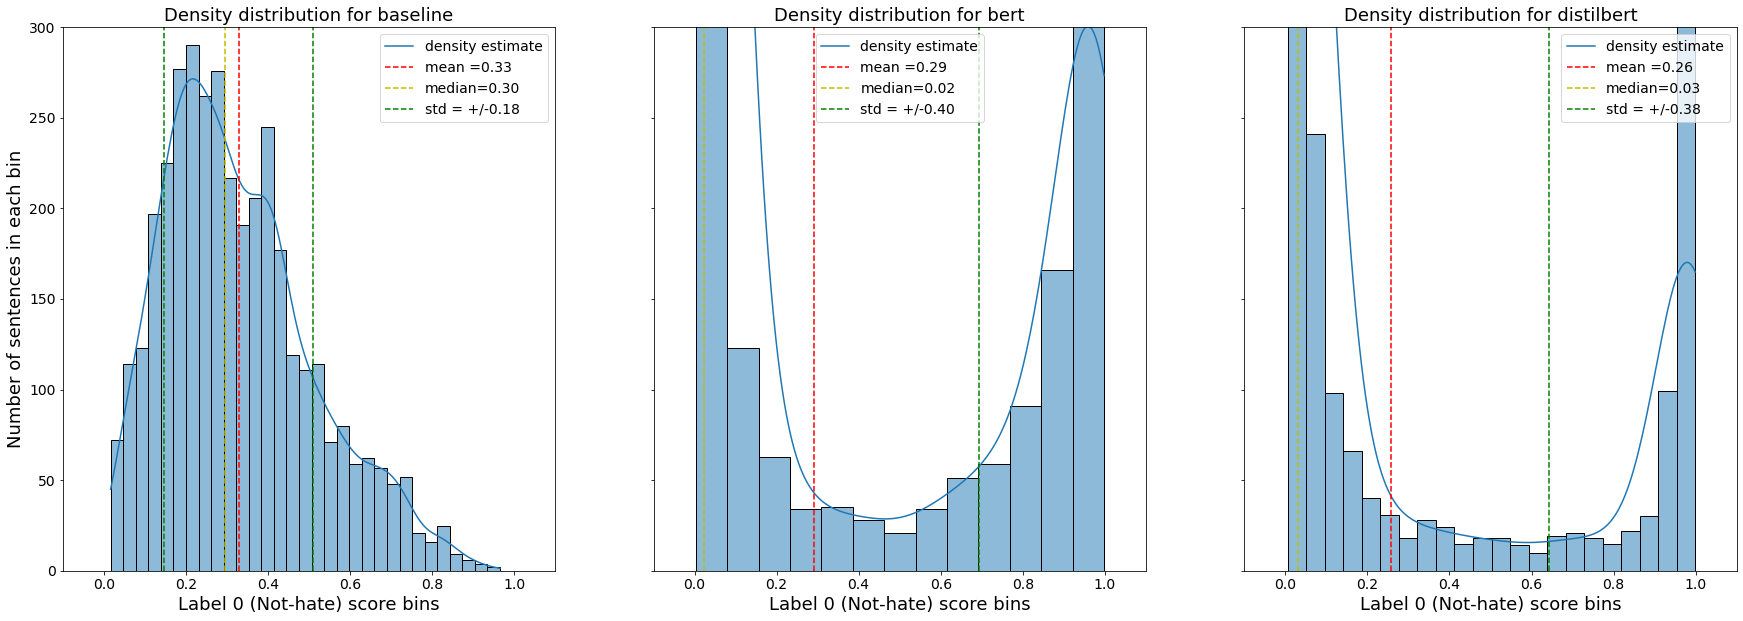

In [24]:
# Plot the density distribution of label 0 (Not-hate)
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot each one of the density functions
for i, model in enumerate(df.model.unique()):
    ax = axes[i]
    sns.histplot(x="score_0", data=df[df.model == model], ax=ax, kde=True)
    mean = df[df.model == model].score_0.mean()
    std = df[df.model == model].score_0.std()
    median = df[df.model == model].score_0.median()

    ax.set_xlabel("Label 0 (Not-hate) score bins")
    ax.set_ylabel("Number of sentences in each bin")
    ax.axvline(mean, color="r", linestyle="--")
    ax.axvline(median, color="y", linestyle="--")
    ax.axvline(mean + std, color="g", linestyle="--")
    ax.axvline(mean - std, color="g", linestyle="--")
    ax.legend(
        [
            "density estimate",
            f"mean ={mean:.2f}",
            f"median={median:.2f}",
            f"std = +/-{std:.2f}",
        ]
    )
    
    # put every plot in the same scale
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0, 300])
    ax.label_outer()

    ax.set_title(f"Density distribution for {model}")

Density distribution of label 1 (Hate)

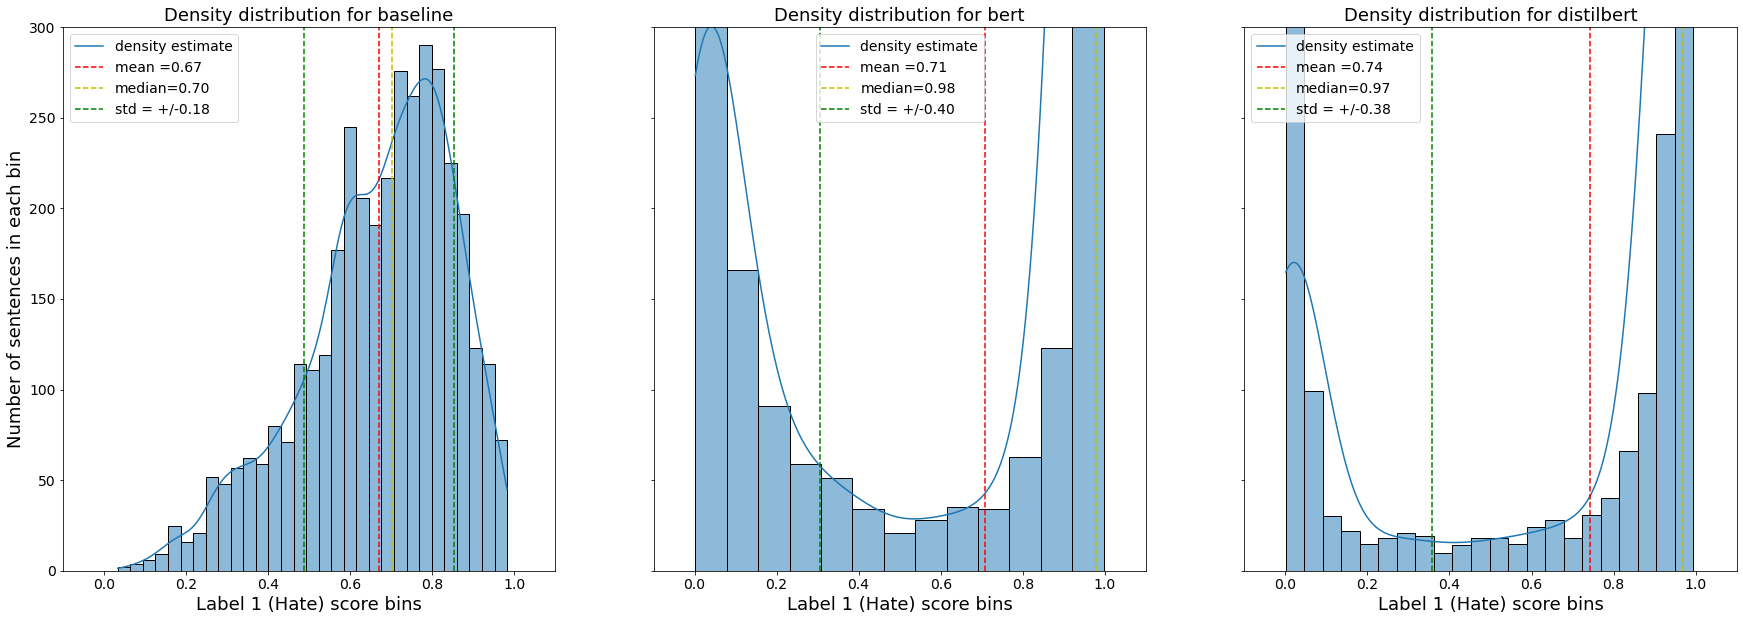

In [25]:
# Plot the density distribution of score 1
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot each one of the density functions
for i, model in enumerate(df.model.unique()):
    ax = axes[i]
    sns.histplot(x="score_1", data=df[df.model == model], ax=ax, kde=True)
    mean = df[df.model == model].score_1.mean()
    std = df[df.model == model].score_1.std()
    median = df[df.model == model].score_1.median()

    ax.set_xlabel("Label 1 (Hate) score bins")
    ax.set_ylabel("Number of sentences in each bin")
    ax.axvline(mean, color="r", linestyle="--")
    ax.axvline(median, color="y", linestyle="--")
    ax.axvline(mean + std, color="g", linestyle="--")
    ax.axvline(mean - std, color="g", linestyle="--")
    ax.legend(
        [
            "density estimate",
            f"mean ={mean:.2f}",
            f"median={median:.2f}",
            f"std = +/-{std:.2f}",
        ]
    )
    
    # put every plot in the same scale
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0, 300])
    ax.label_outer()

    ax.set_title(f"Density distribution for {model}")

Visualization on the data points, their class and the best threshold obtained

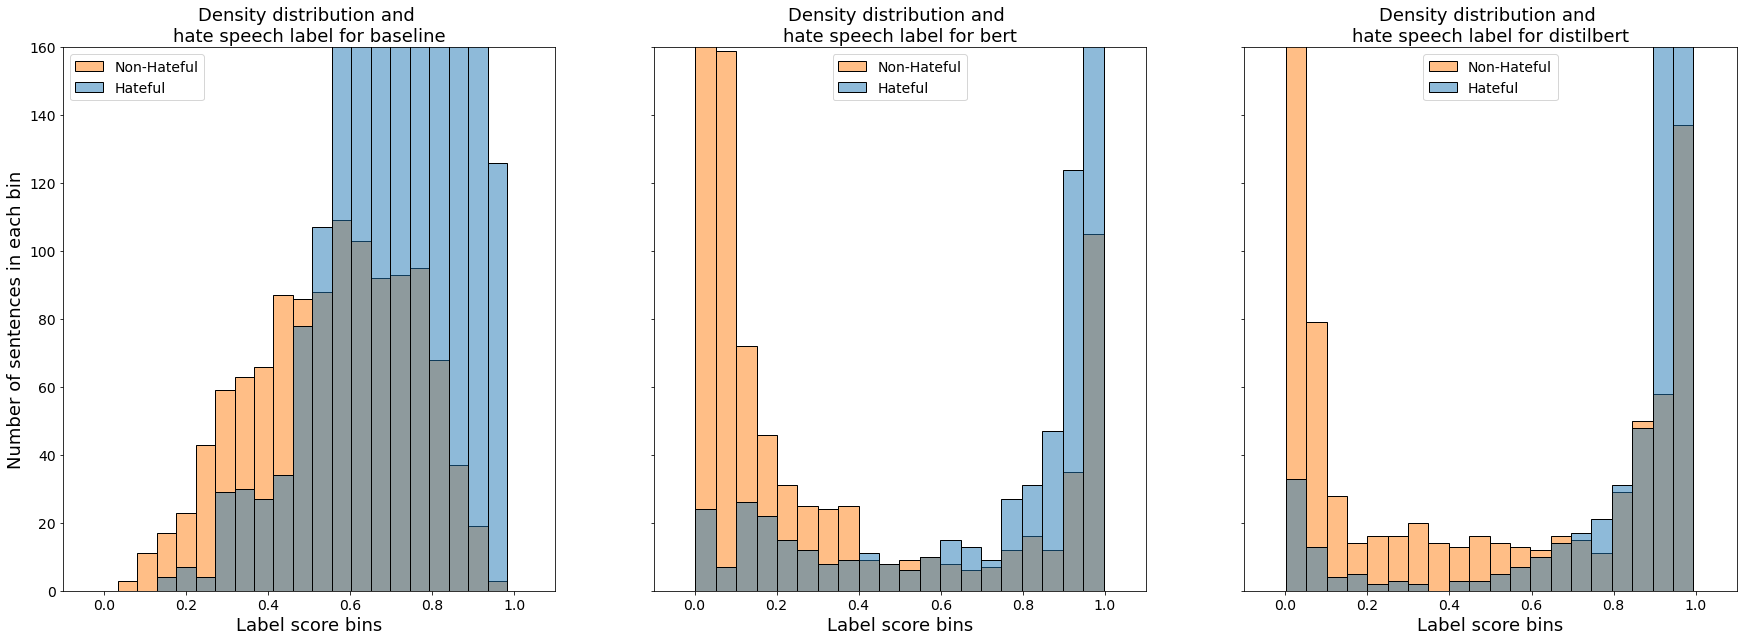

In [26]:
# This chart provides a visualization on the data points, their class and the best threshold obtained.
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot each model
for i, model in enumerate(df.model.unique()):

    ax = axes[i]

    sns.histplot(df[df.model == model], x="score_1", hue="label", bins=20, ax=ax)

    ax.set(
        xlabel="Label score bins",
        title=f"Density distribution and \nhate speech label for {model}",
    )
    ax.set_ylabel("Number of sentences in each bin"),
    ax.legend(
        [
            "Non-Hateful",
            "Hateful",
        ]
    )

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0, 160])
    ax.label_outer()

---
**Considerations:**

* Our models density distribution ('bert' and 'distilbert') behaves like an U-Shaped distribution.
* The 'baseline' model density distribution behaves like a gaussian distribution (bell-shaped curve).
* Our models density distribution ('bert' and 'distilbert') have two peaks, one close to zero and the other close to 1.
* The 'distilbert' model distribution has a threshold closer to 0.7, being 'optimistic' about the label 0 (Not-hate).
* The 'baseline' model distribution has a high overlap, indicating the low performance of this model.
---

## 4. Evaluation

In this section, we are going to use different evaluations metrics to report the performance of each model in the HateCheck set. The following metrics will be used: 

* **ROC curve**
* **Precision vs recall curve**
* **Classification metrics** (precision, recall, f-score).

In [27]:
import numpy as np
from sklearn.metrics import roc_curve, auc

### 4.1. ROC Curve

To compare different models, we plot the ROC curve and measure the area under the curve (AUC).

An [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

* True Positive Rate
* False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

* TPR = TP / TP + FN

False Positive Rate (FPR) is defined as follows:

* FPR = FP / FP + TN

With the ROC curve, we can measure the **area under the curve (AUC)**. AUC represents the probability that a random positive example (1 - Hate) is positioned to the right of a random negative (0 - Not-hate) example. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

This section shows the AUC - ROC curve calculations for our models.

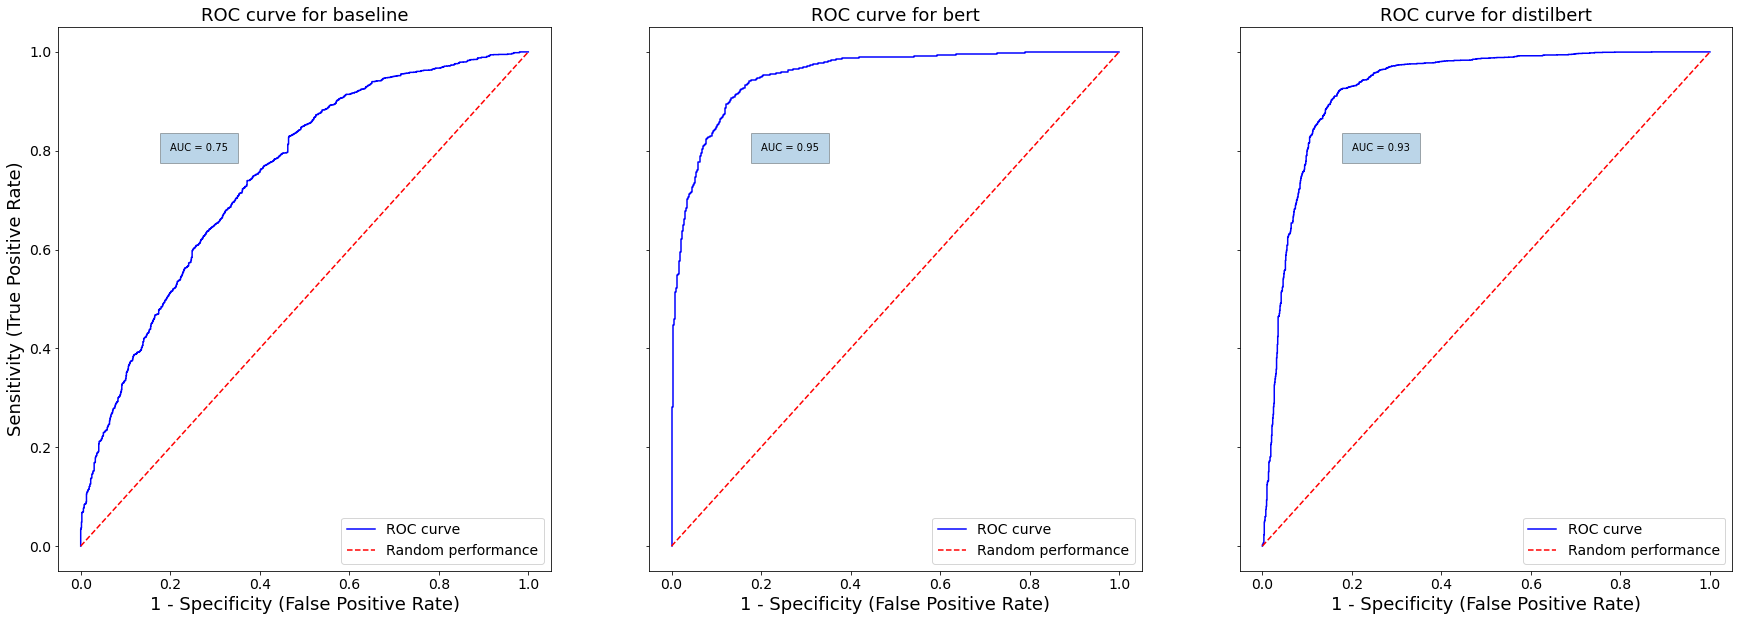

In [28]:
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot the ROC curve for each model being evaluated
for i, model in enumerate(df.model.unique()):
    scores = df[df.model == model]["score_1"]
    y = np.array(
        [1 if label == "hateful" else 0 for label in df[df.model == model]["label"]]
    )

    fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
    auc_score = auc(fpr, tpr)

    ax = axes[i]
    ax.plot(fpr, tpr, "b", label=f"ROC curve", axes=axes[i])
    ax.set_title(f"ROC curve for {model}")
    ax.text(0.2, 0.8, f'AUC = {auc_score:.2f}', bbox={'alpha': 0.3, 'pad': 10})
    ax.plot([0, 1], [0, 1], "r--", label="Random performance")
    ax.legend(loc="lower right")
    ax.set_ylabel("Sensitivity (True Positive Rate)")
    ax.set_xlabel("1 - Specificity (False Positive Rate)")
    ax.label_outer()

---
**Considerations:**

* By inspecting the behaviour for the ROC curve, we can see that the area under the curve (AUC) for our models 'bert' (0.95) and 'distilbert' (0.93) are much higher when compared with the 'baseline' (0.75). This demonstrate that our models have better performance on predicting if a sentence is hateful or not.
* The performance of the 'distilbert' model is very close to the performance of the 'bert' model, indicating that both fit well the problem.
* ROC curves for 'bert' and 'distilbert' models are close to 1 (best score) which shows that, even with the complexity of the problem, our models are able to predict the correct labels.
---

### 4.2. Precision vs Recall curve

The [Precision vs Recall curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) compute precision-recall pairs for different probability thresholds. It is usual to compare the models when we have a strong imbalance problems.

Similar to the ROC curve, we can also measure the [**Average Precision (AP)**](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) that summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. The results close to 1 are better.

In [29]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

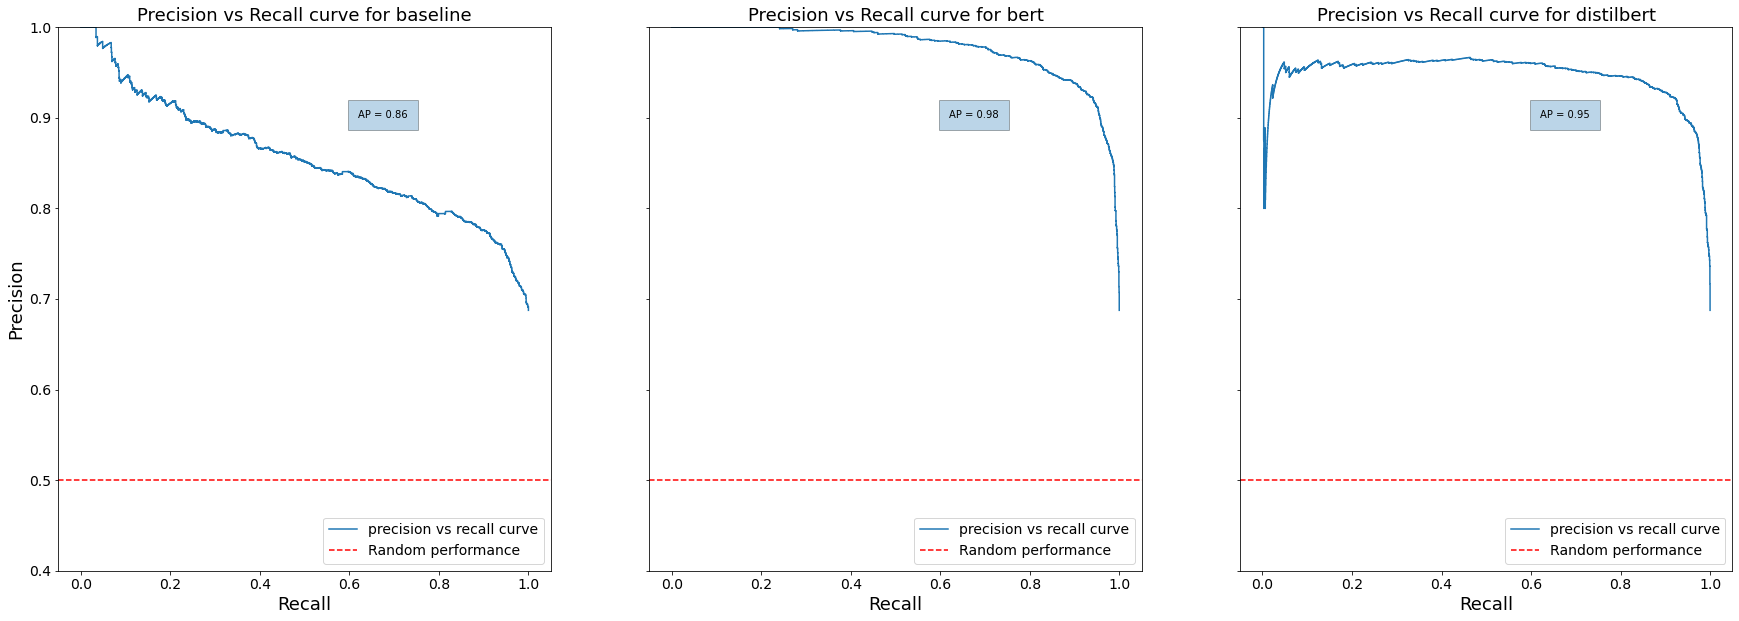

In [30]:
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot the precision vs recall curve for each model being evaluated
for i, model in enumerate(df.model.unique()):
    scores = df[df.model == model]["score_1"]
    y = np.array(
        [1 if label == "hateful" else 0 for label in df[df.model == model]["label"]]
    )
    precision, recall, thresholds = precision_recall_curve(y, scores, pos_label=1)

    # measure the average precision score
    ap_score = average_precision_score(y, scores)
    
    ax = axes[i]
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax, label=f"precision vs recall curve")

    ax.set_title(f"Precision vs Recall curve for {model}")
    ax.axhline(0.5, ls="--", color="r", label="Random performance")
    ax.text(0.62, 0.9, f'AP = {ap_score:.2f}', bbox={'alpha': 0.3, 'pad': 10})
    ax.legend(loc="lower right")
    
    ax.set_ylim([0.4, 1])
    ax.label_outer()

---
**Considerations:**
* The Precision vs Recall curves shows the good performance of 'bert' and 'distilbert' models in predicting the right labels.
* The best performance was for the 'bert' model with 0.98 of Average Precision.
---

### 4.3. Binary Classification

In this section, we want to measure the performance of a classification setup. In this way, we want to predict the label in the HateCheck set by using the probability score provided by each model.

#### 4.3.1. Prediction

In [54]:
def binary_classifier(value, threshold):
    if value > threshold:
        return "hateful"
    else:
        return "non-hateful"


# compute the precision of each example using a mocked threshold
df["prediction"] = df.apply(
    lambda row: binary_classifier(float(row["score_1"]), 0.5), axis=1
)

In [55]:
df.head()

,text,label,model,score_0,score_1,prediction
0,I hate women.,hateful,baseline,0.509703,0.490297,non-hateful
1,I hate women.,hateful,bert,0.095746,0.904254,hateful
2,I hate women.,hateful,distilbert,0.038795,0.961205,hateful
3,I hate trans people.,hateful,baseline,0.441234,0.558766,hateful
4,I hate trans people.,hateful,bert,0.013164,0.986836,hateful


#### 4.3.2. Classification Report

For each one of the classification classes, we can mesure the following classification metrics:

* **precision** - TP / (TP + FP) - the number of correcly classified in this class divided by the total number of elements labelled as belonging to the given class [[ref](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))];
* **recall** - TP / (TP + FN) - the number of correcly classified in this class divided by the total number of elements that actually belong to this class [[ref](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))];
* **f1** - 2*(precion+recall)/(precision+recall) - weighted average of the precision and recall.

In addition, for each classifier, disregarding the class, we can measure the overall accuracy:

* **accuracy** - the number of correctly classified over the number of all sentences, i.e, (TP+TN) / (TP+TN+FP+FN)

In [57]:
from sklearn.metrics import classification_report
from src.data.text_preprocessing import convert_labels

In [58]:
# Convert labels to int
label2int = {'non-hateful': 0, 'hateful': 1}

In [61]:
# plot for each model
for i, model in enumerate(df.model.unique()):
    y_true = df[df.model == model]["label"].apply(lambda x: label2int[x])
    y_pred = df[df.model == model]["prediction"].apply(lambda x: label2int[x])
    print(model)
    print(classification_report(y_true, y_pred, target_names=["Not-hate", "Hate"]))

baseline
              precision    recall  f1-score   support

    Not-hate       0.69      0.38      0.49      1165
        Hate       0.77      0.92      0.84      2563

    accuracy                           0.75      3728
   macro avg       0.73      0.65      0.66      3728
weighted avg       0.74      0.75      0.73      3728

bert
              precision    recall  f1-score   support

    Not-hate       0.87      0.81      0.84      1165
        Hate       0.92      0.94      0.93      2563

    accuracy                           0.90      3728
   macro avg       0.89      0.88      0.88      3728
weighted avg       0.90      0.90      0.90      3728

distilbert
              precision    recall  f1-score   support

    Not-hate       0.92      0.70      0.79      1165
        Hate       0.88      0.97      0.92      2563

    accuracy                           0.89      3728
   macro avg       0.90      0.83      0.86      3728
weighted avg       0.89      0.89      0.88      

#### 4.3.3. Confusion Matrix

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

The confusion matrix shows us how the classification occurred in each class and how many are:

* True Positives (model predicted 1 = hate = hateful sentence -> right class)
* True Negatives (model predicted 0 = nothate = non-hateful sentence -> right class)
* False Positives (model predicted 1 = hate = hateful sentence -> wrong class)
* False Negatives (model predicted 0 = nothate = non-hateful sentence -> wrong class).

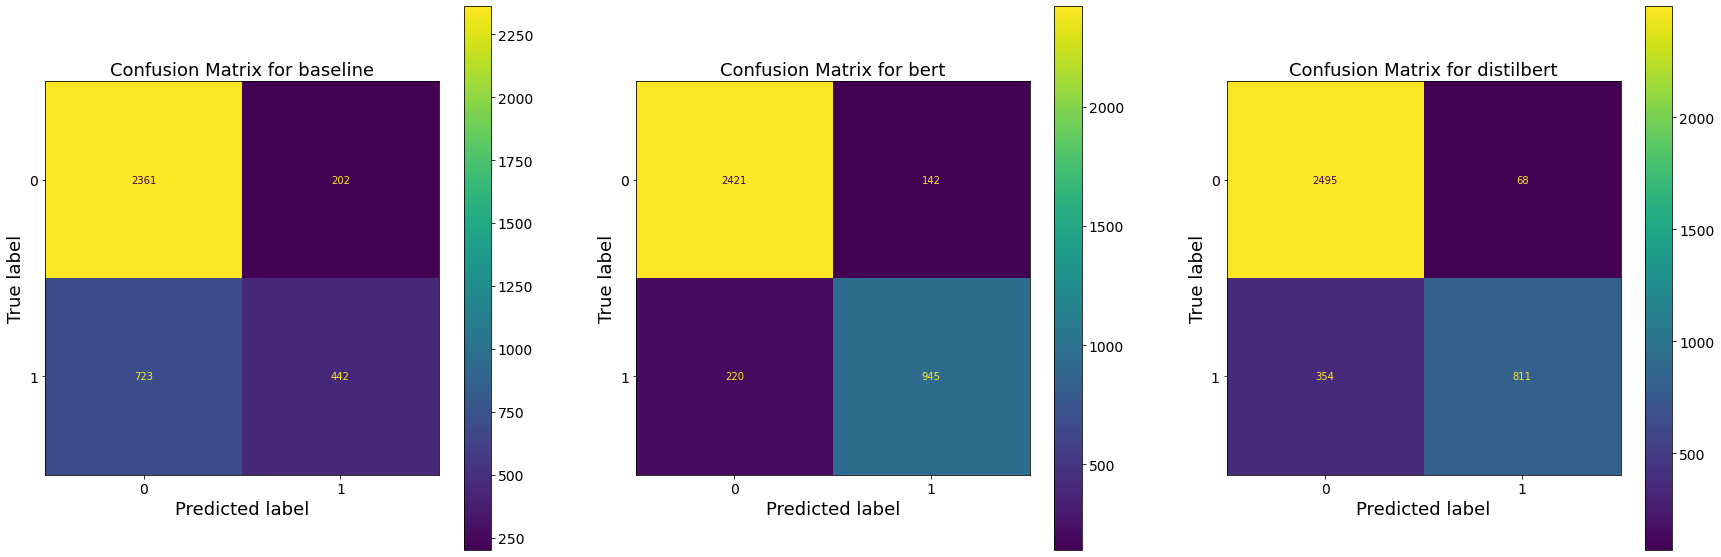

In [63]:
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot for each model
for i, model in enumerate(df.model.unique()):
    ax = axes[i]
    cm = confusion_matrix(df[df.model == model]["label"], df[df.model == model]["prediction"])
    cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax)
    ax.set_title(f"Confusion Matrix for {model}")

---
**Considerations:**
* We observed a better capability in our 'bert' model to balance between precision (0.92) and recall (0.94) which lead to a good f1-score (0.93) for the 'Hate' class.
* The 'bert' model has a higher f1-score (0.84) when compared with the 'distilbert' model (0.79) for the 'Not-hate' class.
* As the 'distilbert' model is optimistic regarding the 'Not-hate' class (threshold 0.7), it classifies more hateful sentences as non-hateful than the opposite (high precision vs low recall for the 'Not-hate' class).
* The 'bert' model performs better in detecting hate than the 'distilbert'.
* We observe the 'baseline' tendency to everestimate the non-hateful prediction. As it includes most of the examples as 'Not-hate', it fails more on predicting the 'Hate' class (low recall - 0.38 and high error rate for 'Not-hate' predictions - #723)
---